**FastMtcnn**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [168]:
import cv2 as cv
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
os.environ['TF_CPPCMINCLOG_LEVEL']='2'

In [3]:
!pip install facenet-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.

In [193]:
import os
from imutils.video import FileVideoStream
import cv2
import time
import glob
from tqdm.notebook import tqdm
import torch
from facenet_pytorch import MTCNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class FastMTCNN(object):
    def __init__(self, stride, resize=1, *args, **kwargs):
        self.stride = stride
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)

    def __call__(self, frames):
        if self.resize != 1:
            frames = [
                cv2.resize(f, (int(f.shape[1] * self.resize), int(f.shape[0] * self.resize)))
                    for f in frames
            ]
        try:
            boxes, _ = self.mtcnn.detect(frames[::self.stride])
        except Exception as e:
            print(f"Skipping batch due to error: {e}")
            return []

        faces = []
        for i, frame in enumerate(frames):
            box_ind = int(i / self.stride)
            if boxes[box_ind] is None:
                continue
            for box in boxes[box_ind]:
                box = [int(b) for b in box]
                faces.append(frame[box[1]:box[3], box[0]:box[2]])
        return faces

fast_mtcnn = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device
)

def run_detection(fast_mtcnn, filenames, output_dir='output'):
    frames = []
    frames_processed = 0
    faces_detected = 0
    batch_size = 60
    start = time.time()

    for filename in tqdm(filenames):
        video_name = os.path.splitext(os.path.basename(filename))[0]
        video_output_dir = os.path.join(output_dir, video_name)
        os.makedirs(video_output_dir, exist_ok=True)

        v_cap = FileVideoStream(filename).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))

        for j in range(v_len):
            frame = v_cap.read()
            if frame is None:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

            #  frames dimensions
            frame_shapes = [f.shape for f in frames]
            if len(set(frame_shapes)) != 1:
                print("Skipping this batch due to unequal dimensions.")
                frames = []
                continue

            if len(frames) >= batch_size or j == v_len - 1:
                faces = fast_mtcnn(frames)
                frames_processed += len(frames)
                faces_detected += len(faces)

                for idx, face in enumerate(faces):
                    try:
                        face_image_path = os.path.join(video_output_dir, f'face_{frames_processed + idx}.jpg')
                        face_rgb = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
                        cv2.imwrite(face_image_path, face_rgb)
                    except Exception as e:

                        pass

                frames = []

                print(
                    f'Frames per second: {frames_processed / (time.time() - start):.3f},',
                    f'faces detected: {faces_detected}\r',
                    end=''
                )

        v_cap.stop()

filenames = glob.glob('/content/drive/MyDrive/Person/*.mp4')
run_detection(fast_mtcnn, filenames, output_dir='faces_output')


  0%|          | 0/3 [00:00<?, ?it/s]

Skipping this batch due to unequal dimensions.


In [192]:
import shutil
shutil.rmtree('/content/faces_output')

In [8]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00


In [194]:
from mtcnn.mtcnn import MTCNN
class FACELOADING:

  def __init__(self,directory):
    self.directory=directory
    self.target_size=(160,160)
    self.X=[];
    self.Y=[];
    self.detector=MTCNN()

  def extract_faces(self,filename):
    img=cv.imread(filename);
    img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
    face=self.detector.detect_faces(img)
    x,y,w,h=face[0]['box']
    my_face=img[y:y+h,x:x+w]
    face_arr=cv.resize(my_face,self.target_size)
    return face_arr

  def load_faces(self,dir):
    FACES=[]
    items=os.listdir(dir)
    for img in items:
      try:
        path=dir+img
        face=self.extract_faces(path)
        FACES.append(face)
      except Exception as e:
          pass
    return FACES

  def load_classes(self):
    for sub in os.listdir(self.directory):
      path=self.directory +'/'+ sub + '/'
      FACES=self.load_faces(path)
      labels=[sub for _ in range(len(FACES))]

      print(f"LOADED SUCCESSFULLY: {len(labels)}")

      self.X.extend(FACES)
      self.Y.extend(labels)

    return np.asarray(self.X),np.asarray(self.Y)

  def plot_images(self):
    for num,img in enumerate(self.X):
      ncols=3
      nrows=len(self.Y)//ncols+2
      plt.subplot(nrows,ncols,num+1)
      plt.imshow(img)
      plt.axis('off')

In [195]:
faceloading=FACELOADING('/content/faces_output/')
X,Y=faceloading.load_classes()

LOADED SUCCESSFULLY: 132
LOADED SUCCESSFULLY: 116
LOADED SUCCESSFULLY: 145


In [196]:
Y

array(['Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 

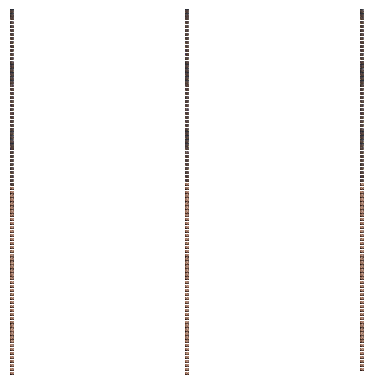

In [52]:
faceloading.plot_images()

In [31]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=8d8a9ba61c4a0e97689bd70acfcfd3a5957bf9007fefcb1bb58b3e350b93c74c
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [197]:
from keras_facenet import FaceNet
embedder =FaceNet()

def get_embedding(face_img):
  face_img=face_img.astype('float32') #3D(160,160,3)
  face_img=np.expand_dims(face_img,axis=0) #4D (none x 160 x 160 x 3)
  yhat=embedder.embeddings(face_img) #gets features of image in 1 X 512 after passing to FaceNet
  return yhat[0] #512D img (1x 1x 512)

In [198]:
EMBEDDED_X=[]
for img in X:
  EMBEDDED_X.append(get_embedding(img))
EMBEDDED_X =np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [199]:

Y

array(['Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin',
       'Arthwin', 'Arthwin', 'Arthwin', 'Arthwin', 

In [200]:
np.savez_compressed('faces_embeddings.npz',EMBEDDED_X,Y)

In [201]:
from sklearn.preprocessing import LabelEncoder
encoder =LabelEncoder()
encoder.fit(Y)
Y=encoder.transform(Y)

In [202]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [203]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(EMBEDDED_X,Y,shuffle=True,random_state=17)

In [204]:
from sklearn.svm import SVC
model=SVC(kernel='linear',probability=True)
model.fit(X_train,Y_train)

SVC(kernel='linear', probability=True)

In [205]:
ypreds_train=model.predict(X_train)
ypreds_test=model.predict(X_test)

In [206]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train,ypreds_train)
accuracy_score(Y_test,ypreds_test)

1.0

**Testing The Model**

In [207]:
faceload=FACELOADING('/content/faces_output')
Faces=faceload.extract_faces("/content/faces_output/Arthwin/face_358.jpg")
Faces
testim=get_embedding(Faces)
ypred=model.predict([testim])
encoder.inverse_transform(ypred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


array(['Arthwin'], dtype='<U8')

In [208]:
import pickle
with open("svm_model",'wb') as f:
  pickle.dump(model,f)